In [ ]:
import os
import argparse as ap
import urllib.request
from zipfile import ZipFile

import h5py
import numpy as np
import scipy.io
from tqdm import tqdm

# see: http://rgbd.cs.princeton.edu/ in section Data and Annotation
DATASET_URL = 'http://rgbd.cs.princeton.edu/data/SUNRGBD.zip'
DATASET_TOOLBOX_URL = 'http://rgbd.cs.princeton.edu/data/SUNRGBDtoolbox.zip'


class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_file(url, output_filepath, display_progressbar=False):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1],
                             disable=not display_progressbar) as t:
        urllib.request.urlretrieve(url,
                                   filename=output_filepath,
                                   reporthook=t.update_to)


if __name__ == '__main__':
    # argument parser
    parser = ap.ArgumentParser(
        description='Prepare SUNRGBD dataset for segmentation.')
    parser.add_argument('dataset_sunrgbd', type=str,
                        help='path where to store dataset')
    args = parser.parse_args()

    # expand user
    output_path = os.path.expanduser(args.output_path)

    os.makedirs(output_path, exist_ok=True)

    toolbox_dir = os.path.join(output_path, 'SUNRGBDtoolbox')

    # download and extract data
    if not os.path.exists(toolbox_dir):
        zip_file_path = os.path.join(output_path, 'SUNRGBDtoolbox.zip')
        download_file(DATASET_TOOLBOX_URL, zip_file_path,
                      display_progressbar=True)
        with ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(os.path.dirname(zip_file_path))
        os.remove(zip_file_path)

    zip_file_path = os.path.join(output_path, 'SUNRGBD.zip')
    if not os.path.exists(zip_file_path):
        download_file(DATASET_URL, zip_file_path,
                      display_progressbar=True)
    print('Extract images')
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(zip_file_path))
    os.remove(zip_file_path)

    # extract labels from SUNRGBD toolbox
    print('Extract labels from SUNRGBD toolbox')
    SUNRGBDMeta_dir = os.path.join(toolbox_dir, 'Metadata/SUNRGBDMeta.mat')
    allsplit_dir = os.path.join(toolbox_dir, 'traintestSUNRGBD/allsplit.mat')
    SUNRGBD2Dseg_dir = os.path.join(toolbox_dir, 'Metadata/SUNRGBD2Dseg.mat')
    img_dir_train = []
    depth_dir_train = []
    label_dir_train = []
    img_dir_test = []
    depth_dir_test = []
    label_dir_test = []

    SUNRGBD2Dseg = h5py.File(SUNRGBD2Dseg_dir, mode='r', libver='latest')

    # load the data from the matlab file
    SUNRGBDMeta = scipy.io.loadmat(SUNRGBDMeta_dir, squeeze_me=True,
                                   struct_as_record=False)['SUNRGBDMeta']
    split = scipy.io.loadmat(allsplit_dir, squeeze_me=True,
                             struct_as_record=False)
    split_train = split['alltrain']

    seglabel = SUNRGBD2Dseg['SUNRGBD2Dseg']['seglabel']

    for i, meta in tqdm(enumerate(SUNRGBDMeta)):
        meta_dir = '/'.join(meta.rgbpath.split('/')[:-2])
        real_dir = meta_dir.split('/n/fs/sun3d/data/SUNRGBD/')[1]
        depth_bfx_path = os.path.join(real_dir, 'depth_bfx/' + meta.depthname)
        rgb_path = os.path.join(real_dir, 'image/' + meta.rgbname)

        label_path = os.path.join(real_dir, 'label/label.npy')
        label_path_full = os.path.join(output_path, 'SUNRGBD', label_path)

        # save segmentation (label_path) as numpy array
        if not os.path.exists(label_path_full):
            os.makedirs(os.path.dirname(label_path_full), exist_ok=True)
            label = np.array(
                SUNRGBD2Dseg[seglabel[i][0]][:].transpose(1, 0)).\
                astype(np.uint8)
            np.save(label_path_full, label)

        if meta_dir in split_train:
            img_dir_train.append(os.path.join('SUNRGBD', rgb_path))
            depth_dir_train.append(os.path.join('SUNRGBD', depth_bfx_path))
            label_dir_train.append(os.path.join('SUNRGBD', label_path))
        else:
            img_dir_test.append(os.path.join('SUNRGBD', rgb_path))
            depth_dir_test.append(os.path.join('SUNRGBD', depth_bfx_path))
            label_dir_test.append(os.path.join('SUNRGBD', label_path))

    # write file lists
    def _write_list_to_file(list_, filepath):
        with open(os.path.join(output_path, filepath), 'w') as f:
            f.write('\n'.join(list_))
        print('written file {}'.format(filepath))

    _write_list_to_file(img_dir_train, 'train_rgb.txt')
    _write_list_to_file(depth_dir_train, 'train_depth.txt')
    _write_list_to_file(label_dir_train, 'train_label.txt')
    _write_list_to_file(img_dir_test, 'test_rgb.txt')
    _write_list_to_file(depth_dir_test, 'test_depth.txt')
    _write_list_to_file(label_dir_test, 'test_label.txt')

In [ ]:
import os

import numpy as np
import cv2



class SUNRGBD(SUNRBDBase, DatasetBase):
    def __init__(self,
                 data_dir=None,
                 split='train',
                 depth_mode='refined',
                 with_input_orig=False):
        super(SUNRGBD, self).__init__()

        self._n_classes = self.N_CLASSES
        self._cameras = ['realsense', 'kv2', 'kv1', 'xtion']
        assert split in self.SPLITS, \
            f'parameter split must be one of {self.SPLITS}, got {split}'
        self._split = split
        assert depth_mode in ['refined', 'raw']
        self._depth_mode = depth_mode
        self._with_input_orig = with_input_orig

        if data_dir is not None:
            data_dir = os.path.expanduser(data_dir)
            self._data_dir = data_dir
            self.img_dir, self.depth_dir, self.label_dir = \
                self.load_file_lists()
        else:
            print(f"Loaded {self.__class__.__name__} dataset without files")

        self._class_names = self.CLASS_NAMES_ENGLISH
        self._class_colors = np.array(self.CLASS_COLORS, dtype='uint8')

        # note that mean and std differ depending on the selected depth_mode
        # however, the impact is marginal, therefore, we decided to use the
        # stats for refined depth for both cases
        # stats for raw: mean: 18320.348967710495, std: 8898.658819551309
        self._depth_mean = 19025.14930492213
        self._depth_std = 9880.916071806689

    @property
    def cameras(self):
        return self._cameras

    @property
    def class_names(self):
        return self._class_names

    @property
    def class_names_without_void(self):
        return self._class_names[1:]

    @property
    def class_colors(self):
        return self._class_colors

    @property
    def class_colors_without_void(self):
        return self._class_colors[1:]

    @property
    def n_classes(self):
        return self._n_classes + 1

    @property
    def n_classes_without_void(self):
        return self._n_classes

    @property
    def split(self):
        return self._split

    @property
    def depth_mode(self):
        return self._depth_mode

    @property
    def depth_mean(self):
        return self._depth_mean

    @property
    def depth_std(self):
        return self._depth_std

    @property
    def source_path(self):
        return os.path.abspath(os.path.dirname(__file__))

    @property
    def with_input_orig(self):
        return self._with_input_orig

    def load_image(self, idx):
        if self.camera is None:
            img_dir = self.img_dir[self._split]['list']
        else:
            img_dir = self.img_dir[self._split]['dict'][self.camera]
        fp = os.path.join(self._data_dir, img_dir[idx])
        image = cv2.imread(fp, cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def load_depth(self, idx):
        if self.camera is None:
            depth_dir = self.depth_dir[self._split]['list']
        else:
            depth_dir = self.depth_dir[self._split]['dict'][self.camera]

        if self._depth_mode == 'raw':
            depth_file = depth_dir[idx].replace('depth_bfx', 'depth')
        else:
            depth_file = depth_dir[idx]

        fp = os.path.join(self._data_dir, depth_file)
        depth = cv2.imread(fp, cv2.IMREAD_UNCHANGED)
        return depth

    def load_label(self, idx):
        if self.camera is None:
            label_dir = self.label_dir[self._split]['list']
        else:
            label_dir = self.label_dir[self._split]['dict'][self.camera]

        label = np.load(os.path.join(self._data_dir,
                                     label_dir[idx])).astype(np.uint8)

        return label

    def load_file_lists(self):
        def _get_filepath(filename):
            return os.path.join(self._data_dir, filename)

        img_dir_train_file = _get_filepath('train_rgb.txt')
        depth_dir_train_file = _get_filepath('train_depth.txt')
        label_dir_train_file = _get_filepath('train_label.txt')

        img_dir_test_file = _get_filepath('test_rgb.txt')
        depth_dir_test_file = _get_filepath('test_depth.txt')
        label_dir_test_file = _get_filepath('test_label.txt')

        img_dir = dict()
        depth_dir = dict()
        label_dir = dict()

        for phase in ['train', 'test']:
            img_dir[phase] = dict()
            depth_dir[phase] = dict()
            label_dir[phase] = dict()

        img_dir['train']['list'], img_dir['train']['dict'] = \
            self.list_and_dict_from_file(img_dir_train_file)
        depth_dir['train']['list'], depth_dir['train']['dict'] = \
            self.list_and_dict_from_file(depth_dir_train_file)
        label_dir['train']['list'], label_dir['train']['dict'] = \
            self.list_and_dict_from_file(label_dir_train_file)

        img_dir['test']['list'], img_dir['test']['dict'] = \
            self.list_and_dict_from_file(img_dir_test_file)
        depth_dir['test']['list'], depth_dir['test']['dict'] = \
            self.list_and_dict_from_file(depth_dir_test_file)
        label_dir['test']['list'], label_dir['test']['dict'] = \
            self.list_and_dict_from_file(label_dir_test_file)

        return img_dir, depth_dir, label_dir

    def list_and_dict_from_file(self, filepath):
        with open(filepath, 'r') as f:
            file_list = f.read().splitlines()
        dictionary = dict()
        for cam in self.cameras:
            dictionary[cam] = [i for i in file_list if cam in i]

        return file_list, dictionary

    def __len__(self):
        if self.camera is None:
            return len(self.img_dir[self._split]['list'])
        return len(self.img_dir[self._split]['dict'][self.camera])

In [ ]:
train_rgb = 'dataset_sunrgbd/train_rgb.txt'
train_depth = 'dataset_sunrgbd/train_depth.txt'
train_label = 'dataset_sunrgbd/train_label.txt'

test_rgb = 'dataset_sunrgbd/test_rgb.txt'
test_depth = 'dataset_sunrgbd/test_depth.txt'
test_label = 'dataset_sunrgbd/test_label.txt'

In [ ]:
import shutil
import os
 
current_path = os.getcwd()
camara = 'realsense'

src_dir = [train_rgb, train_depth, train_label, test_rgb, test_depth, test_label]
dst_dir = ['dataset_sunrgbd/train_rgb/', 'dataset_sunrgbd/train_depth/', 'dataset_sunrgbd/train_label/', 'dataset_sunrgbd/test_rgb/', 'dataset_sunrgbd/test_depth/', 'dataset_sunrgbd/test_label/']

for i in range (len(src_dir)):
    lines = []
    with open(src_dir[i]) as f:
        lines = f.readlines()
        cont = 0
        for j in lines:
            if j.split('\\')[1].split('/')[0] == camara:
                photo = (j)[:-1]
                shutil.copy('dataset_sunrgbd/' + photo, dst_dir[i] + str(cont) + '.' + j.split('\\')[1].split('/')[-1][:-1].split('.')[-1])
                cont += 1

In [ ]:
import numpy as np
import cv2


label = np.load('dataset_sunrgbd/train_label/0.npy')
print(label.shape)
depth = cv2.imread('dataset_sunrgbd/train_depth/0.png')
print(depth.shape)
rgb = cv2.imread('dataset_sunrgbd/train_rgb/0.jpg')
print(rgb.shape)

In [4]:
import matplotlib.pyplot as plt

def plot_color(ax, color, title="Color"):
    """Displays a color image from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(color)

def plot_depth(ax, depth, title="Depth"):
    """Displays a depth map from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(depth, cmap='Spectral')

def plot_label(ax, labels, title="Label"):
    """Displays a label map from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(labels)

In [ ]:
fig = plt.figure("Labeled Dataset Sample", figsize=(24, 10))

number = 1

ax = fig.add_subplot(1, 3, 1)
plot_color(ax, rgb)

ax = fig.add_subplot(1, 3, 2)
plot_depth(ax, depth)

ax = fig.add_subplot(1, 3, 3)
plot_label(ax, label)

plt.show()

In [6]:
from PIL import Image
import numpy as np
import cv2
from keras.preprocessing.image import img_to_array
import tensorflow as tf

dst_dir = ['dataset_sunrgbd/train_rgb/', 'dataset_sunrgbd/train_depth/', 'dataset_sunrgbd/train_label/', 'dataset_sunrgbd/test_rgb/', 'dataset_sunrgbd/test_depth/', 'dataset_sunrgbd/test_label/']

rgb_data = []
for archivo in os.listdir('dataset_sunrgbd/train_rgb'):
    img = Image.open(os.path.join('dataset_sunrgbd/train_rgb',archivo))
    img = cv2.resize(img_to_array(img), dsize=(640,480), interpolation=cv2.INTER_CUBIC)
    rgb_data.append(np.asarray(img))
    
for archivo in os.listdir('dataset_sunrgbd/test_rgb'):
    img = Image.open(os.path.join('dataset_sunrgbd/test_rgb',archivo))
    img = cv2.resize(img_to_array(img), dsize=(640,480), interpolation=cv2.INTER_CUBIC)
    rgb_data.append(np.asarray(img))
rgb_data = np.array(rgb_data)
print(rgb_data.shape)

depth_data = []
for archivo in os.listdir('dataset_sunrgbd/train_depth'):
    img = Image.open(os.path.join('dataset_sunrgbd/train_depth',archivo))
    img = cv2.resize(img_to_array(img), dsize=(640,480), interpolation=cv2.INTER_CUBIC)
    depth_data.append(np.asarray(img))
    
for archivo in os.listdir('dataset_sunrgbd/test_depth'):
    img = Image.open(os.path.join('dataset_sunrgbd/test_depth',archivo))
    img = cv2.resize(img_to_array(img), dsize=(640,480), interpolation=cv2.INTER_CUBIC)
    depth_data.append(np.asarray(img))
depth_data = np.array(depth_data)
print(depth_data.shape)

label_data = []
for archivo in os.listdir('dataset_sunrgbd/train_label'):
    img = np.load(os.path.join('dataset_sunrgbd/train_label',archivo))
    img = cv2.resize(img_to_array(img), dsize=(640,480), interpolation=cv2.INTER_CUBIC)
    label_data.append(img)

for archivo in os.listdir('dataset_sunrgbd/test_label'):
    img = np.load(os.path.join('dataset_sunrgbd/test_label',archivo))
    img = cv2.resize(img_to_array(img), dsize=(640,480), interpolation=cv2.INTER_CUBIC)
    label_data.append(img)
label_data = np.array(label_data)
print(label_data.shape)

y = tf.keras.utils.to_categorical(label_data, dtype='uint8')
y.shape

(1159, 480, 640, 3)
(1159, 480, 640)
(1159, 480, 640)


In [7]:
np.save('dataset_sunrgbd/x1', rgb_data, allow_pickle=False, fix_imports=False)

In [ ]:
np.save('dataset_sunrgbd/x2', depth_data, allow_pickle=False, fix_imports=False)

In [ ]:
np.save('dataset_sunrgbd/y', label_data, allow_pickle=False, fix_imports=False)

In [ ]:
np.save('dataset_sunrgbd/y_prepared', y, allow_pickle=False, fix_imports=False)

In [1]:
import numpy as np

x1 = np.load('dataset_sunrgbd/x1.npy')
x2 = np.load('dataset_sunrgbd/x2.npy')
y = np.load('dataset_sunrgbd/y.npy')

In [2]:
x2.shape

(1159, 480, 640)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


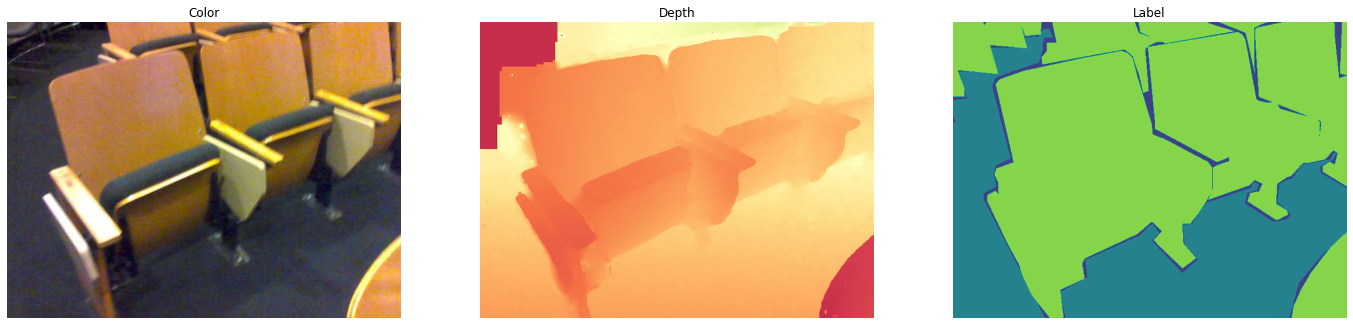

In [7]:
fig = plt.figure("Labeled Dataset Sample", figsize=(24, 10))

number = 1

ax = fig.add_subplot(1, 3, 1)
plot_color(ax, x1[0]/255)

ax = fig.add_subplot(1, 3, 2)
plot_depth(ax, x2[0])

ax = fig.add_subplot(1, 3, 3)
plot_label(ax, y[0])

plt.show()

In [ ]:
import numpy as np

data_dir = np.load('dataset_sunrgbd/y')

tf.keras.utils.to_categorical(
    y, num_classes=32, dtype='int'
)